In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from copy import deepcopy

from util.dataloader import *
from util.preprocessing import *
from util.formatting import *
from util.plot import *

# load cached bison data; replace filepath/dataloading as appropriate
data = cached_bison_data("/Users/audreyder/Bison_Water/syncdatabase_011725.csv")

Data columns: Index(['site_id', 'pump_id', 'timestamp', 'facility_name', 'vibration',
       'thrust temperature', 'suction pressure', 'discharge pressure',
       'flow rate', 'frequency', 'amps', 'ampsa', 'ampsb', 'ampsc', 'volts',
       'voltsa', 'voltsb', 'voltsc', 'meter total'],
      dtype='object')
Number of rows: 279344


In [4]:
twohr_rate_1_min = 120
twohr_rate_5_min = 24

# NOTES
# union city: 33404, one minute -- '2024-12-17 12:00:00'
# siegrist: 33467, five minutes -- '2024-12-17 10:00:00'
# canadian: 57740, one minutes -- '2024-12-13 12:00:00'
# calumet: 33614, five minutes -- '2024-12-13 12:00:00' 69969 is ~midnight sept 1 2024

# OLD -- found starting times based on the above notes by hand
# unioncity_start = 259943 
# seigrist_start = 66050 
# canadian_start = 254170 
# calumet_start = 100021

# Stage 1: Estimate time stamps for when each stage of calibration is happening given a label for when (date, time) calibration begins for a site
# 1. begin with your site id
# 2. specify your query start date and time for calibration 
# 3. find the closest time and date match in the dataframe to your query (default time is 00:00:00 if no time is specified)
# 4. hardcode the different frequencies you know are being calibrated # (Stage 2: automate this based on info given in steps 2 and 3 here)
# 5. format the estimated ground truth for calibration
# 6. plot it

unioncity_id = 33404 # 1
unioncity_startdate = '2024-12-17' # 2
unioncity_startime = '12:00:00'
unioncity_timestamp, unioncity_start = find_closest_time(data[data['site_id']==unioncity_id], unioncity_startdate, query_time=unioncity_startime) # 3
print(unioncity_timestamp)
unioncity_freqs = [46,48,50,52,54,56] # 4
unioncity = format_sitegts(unioncity_start,unioncity_freqs,twohr_rate_5_min) # 5

siegrist_id = 33467
seigrist_startdate = '2024-12-17'
seigrist_starttime = '10:00:00'
seigrist_timestamp, seigrist_start = find_closest_time(data[data['site_id']==siegrist_id], seigrist_startdate, query_time=seigrist_starttime)
seigrist_freqs = [47,49,51,53,55,57] # future: automate based on the above given timestamp
print(seigrist_timestamp)
siegrist = format_sitegts(seigrist_start,seigrist_freqs,twohr_rate_5_min) 

canadian_id = 57740
canadian_startdate = '2024-12-13'
canadian_starttime = '12:00:00'
canadian_timestamp, canadian_start = find_closest_time(data[data['site_id']==canadian_id], canadian_startdate, query_time=canadian_starttime)
print(canadian_timestamp)
canadian_freqs = [44,47,49,51,53,55,57,59] # future: automate based on the above given timestamp
canadian = format_sitegts(canadian_start,canadian_freqs,twohr_rate_1_min)

calumet_id = 33614
calumet_startdate = '2024-12-13'
calumet_starttime = '12:00:00'
calumet_timestamp, calumet_start = find_closest_time(data[data['site_id']==calumet_id], calumet_startdate, query_time=calumet_starttime)
print(calumet_timestamp)
calumet_freqs = [49,51,53,55] # future: automate based on the above given timestamp
calumet = format_sitegts(calumet_start,calumet_freqs,twohr_rate_5_min)

sitegts = {unioncity_id:unioncity, siegrist_id:siegrist, canadian_id:canadian, calumet_id:calumet}

# unioncity_id = 33404 # 1
# unioncity_startdate = '2024-12-15' # 2
# unioncity_startime = '15:05:00'
# unioncity_timestamp, unioncity_start = find_closest_time(data[data['site_id']==unioncity_id], unioncity_startdate, query_time=unioncity_startime) # 3
# print(unioncity_timestamp)
# unioncity_freqs = [46,48,50,52,54,56] # 4
# unioncity = format_sitegts(unioncity_start,unioncity_freqs,twohr_rate_5_min) # 5

# siegrist_id = 33467
# seigrist_startdate = '2024-12-19'
# seigrist_starttime = '11:00:00'
# seigrist_timestamp, seigrist_start = find_closest_time(data[data['site_id']==siegrist_id], seigrist_startdate, query_time=seigrist_starttime)
# seigrist_freqs = [47,49,51,53,55,57] # future: automate based on the above given timestamp
# print(seigrist_timestamp)
# siegrist = format_sitegts(seigrist_start,seigrist_freqs,twohr_rate_5_min) 

# canadian_id = 57740
# canadian_startdate = '2024-12-15'
# canadian_starttime = '09:00:00'
# canadian_timestamp, canadian_start = find_closest_time(data[data['site_id']==canadian_id], canadian_startdate, query_time=canadian_starttime)
# print(canadian_timestamp)
# canadian_freqs = [44,47,49,51,53,55,57,59] # future: automate based on the above given timestamp
# canadian = format_sitegts(canadian_start,canadian_freqs,twohr_rate_1_min)

# calumet_id = 33614
# calumet_startdate = '2024-10-13'
# calumet_starttime = '12:00:00'
# calumet_timestamp, calumet_start = find_closest_time(data[data['site_id']==calumet_id], calumet_startdate, query_time=calumet_starttime)
# print(calumet_timestamp)
# calumet_freqs = [49,51,53,55] # future: automate based on the above given timestamp
# calumet = format_sitegts(calumet_start,calumet_freqs,twohr_rate_5_min)

# sitegts = {unioncity_id:unioncity, siegrist_id:siegrist, canadian_id:canadian, calumet_id:calumet}

# QUICK COMMANDS -- feel free to ignore
# print(data[data['site_id']==33614]) # look at the data for a given site
# s_temp = 259943 
# print(data[s_temp:s_temp+twohr_rate_1_min]) # quickly check the two hour duration based off a start index & given sampling rate
# print(data[data['timestamp']=='2024-12-17 12:00:02'])

2024-12-17 12:00:12
2024-12-17 10:00:19
2024-12-13 12:00:02
2024-12-13 12:00:19


33404


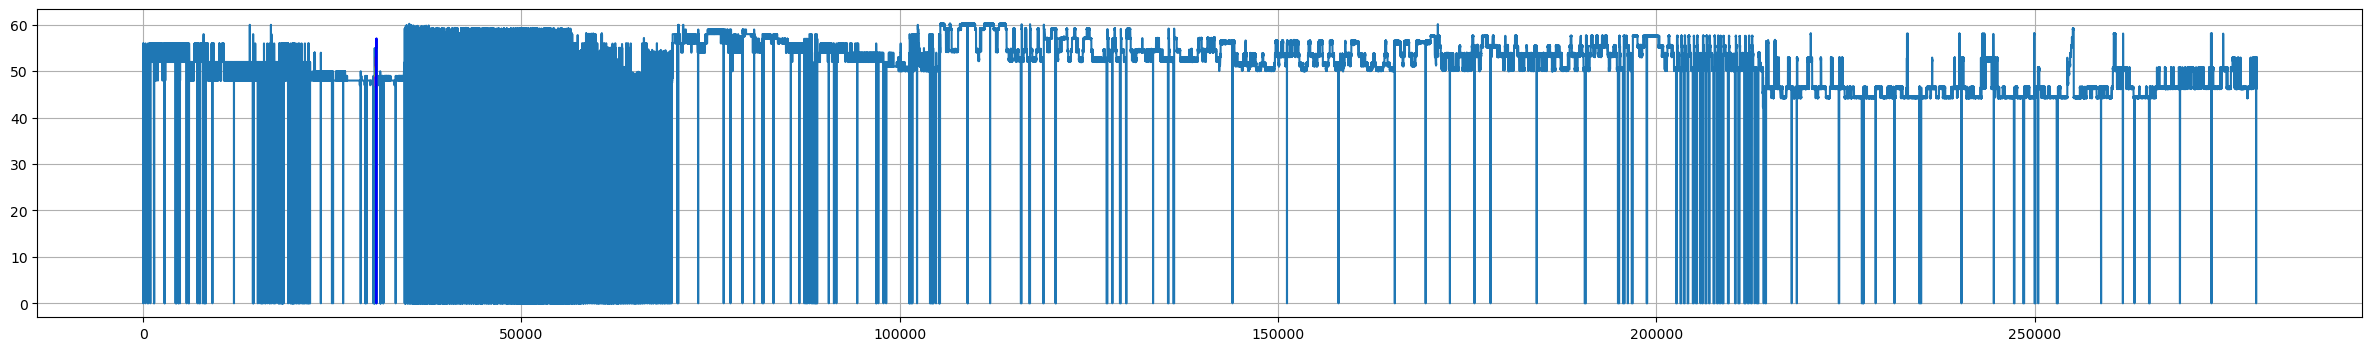

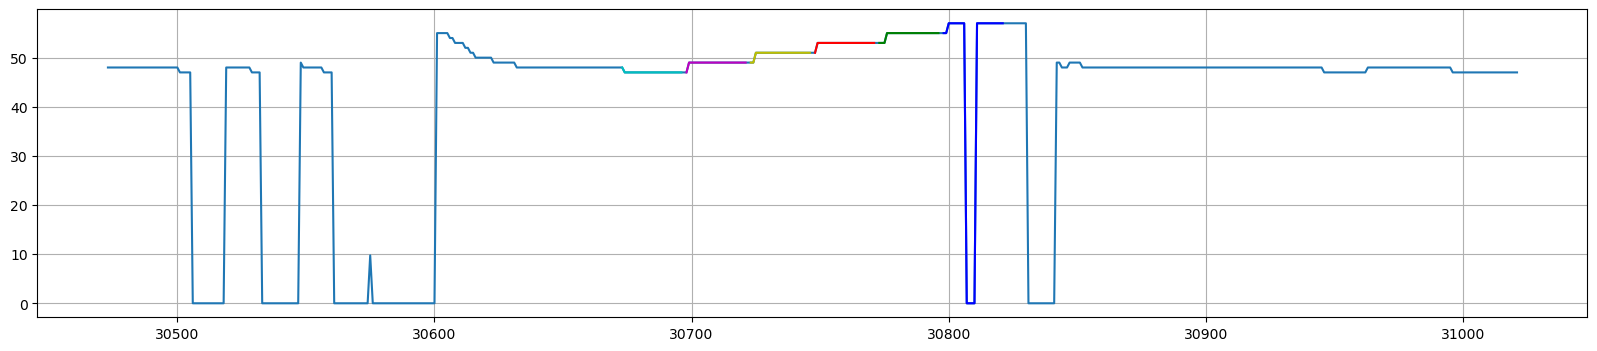

33467


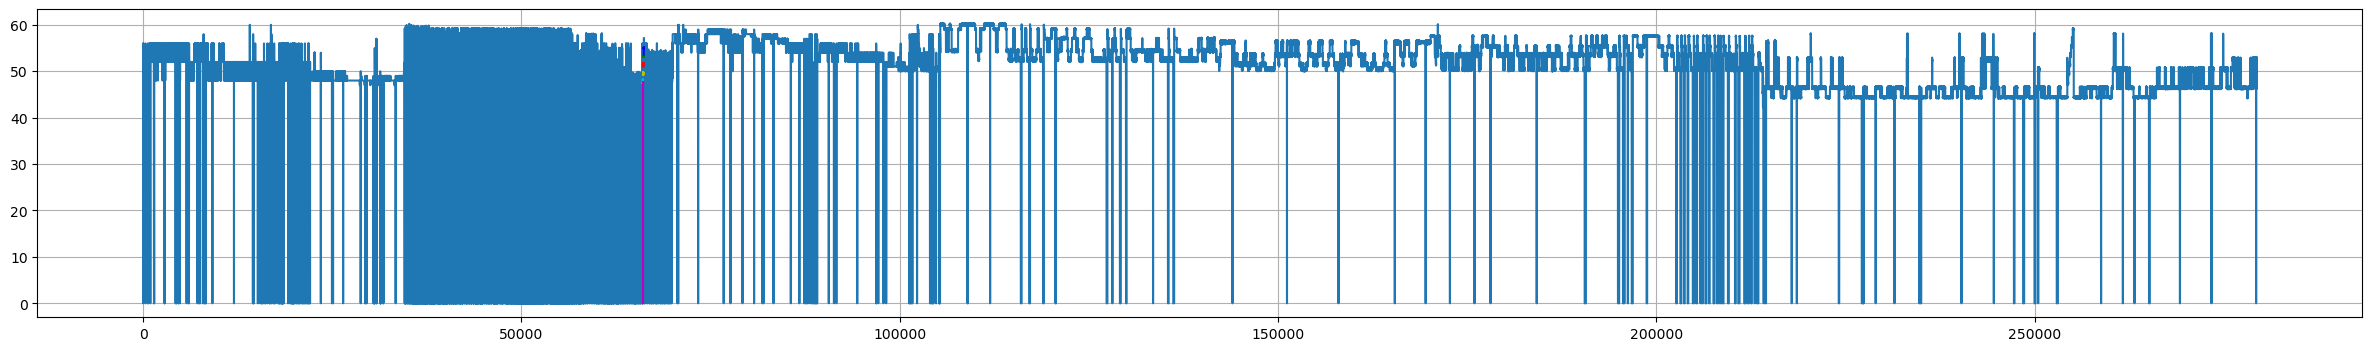

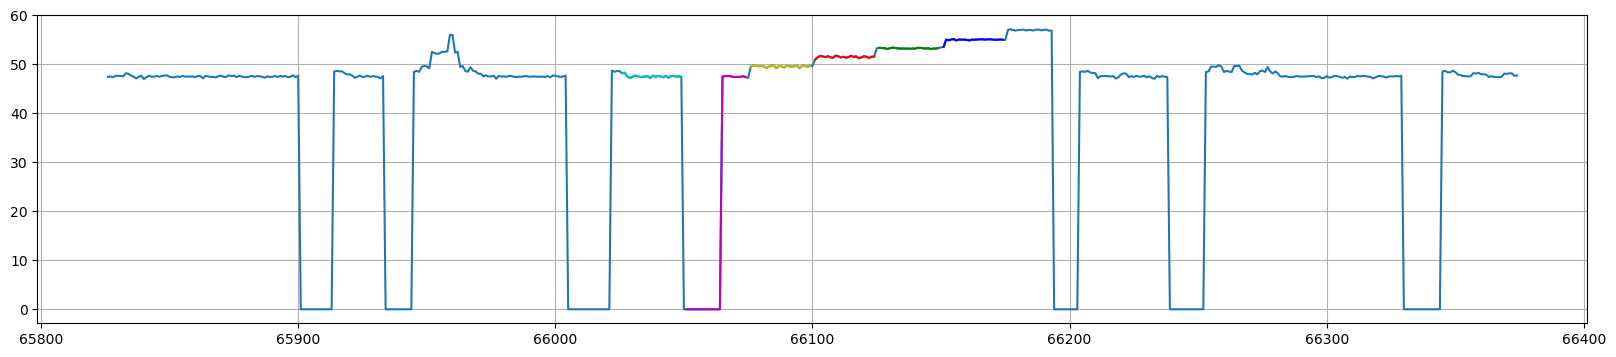

57740


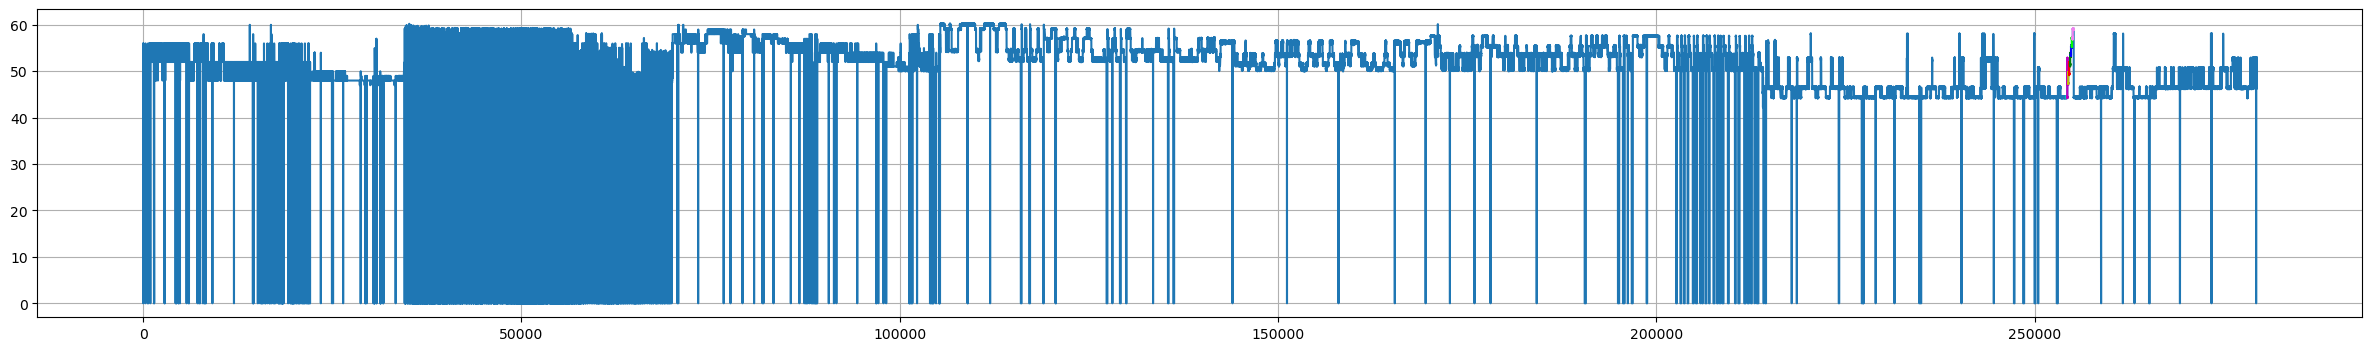

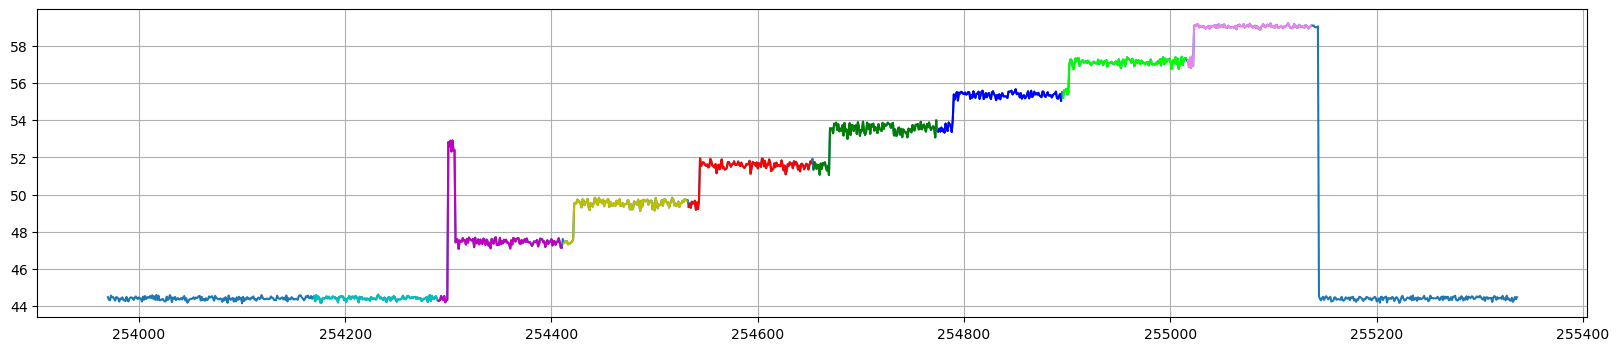

33614


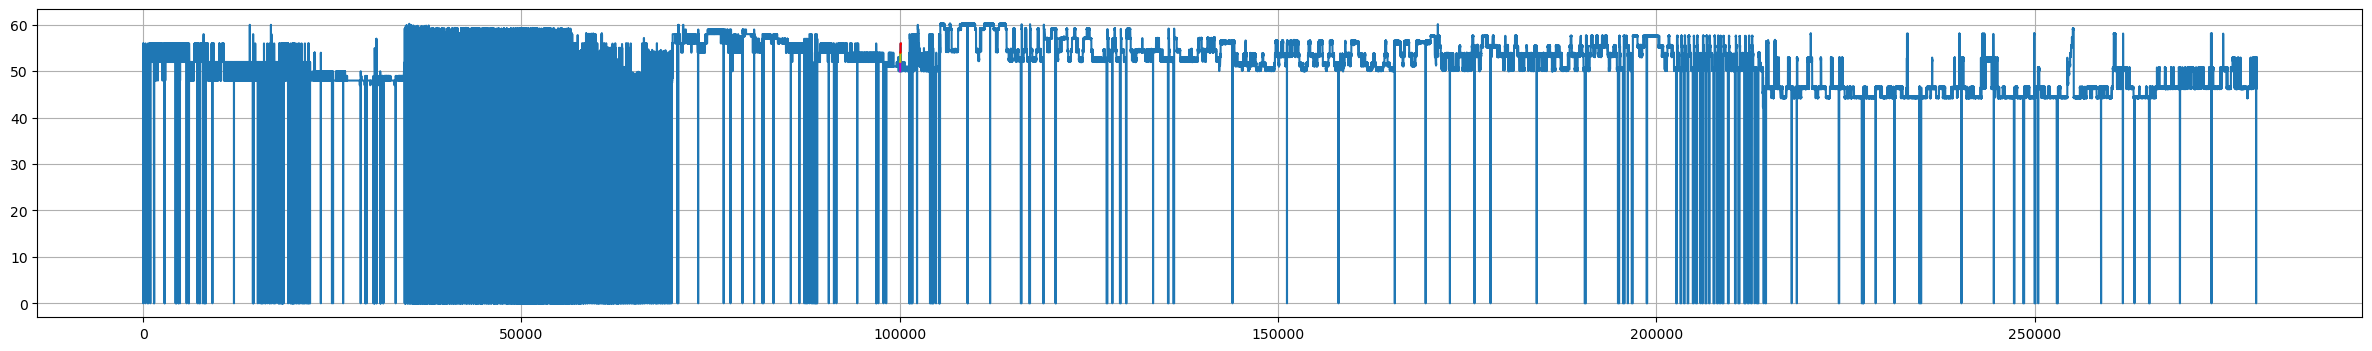

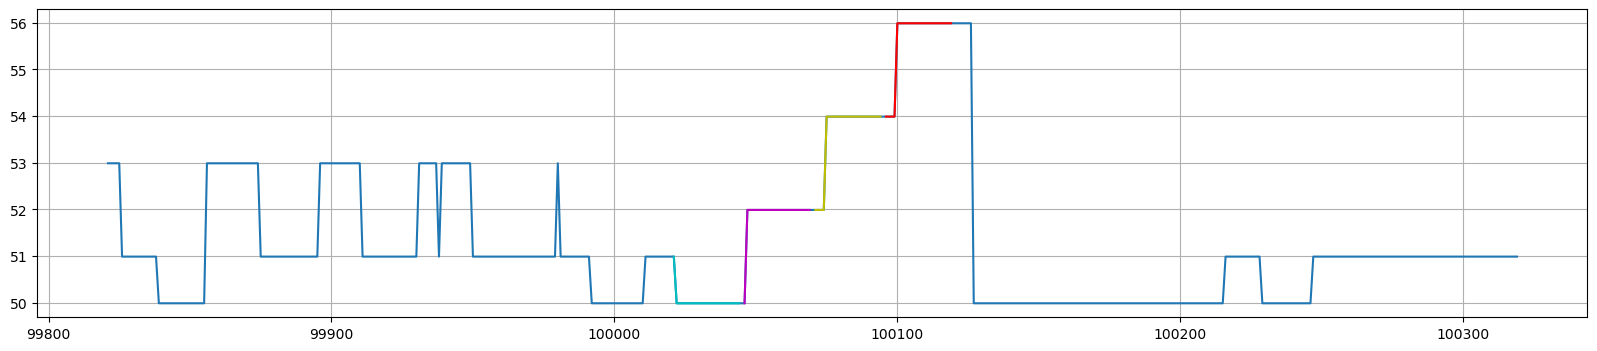

In [5]:
for site_id in sitegts.keys(): # 6
    print(site_id)
    freq_data = data['frequency']
    plot_ts_gt(sitegts, freq_data, site_id)

In [6]:
# copied from sites_info: 
# https://github.com/neuralix-ai/dev_RyanMercer/blob/dev/notebooks/Customers/Bison/2024-12-29_Bison_PumpCurve_x-axisHealth_calibrated_alert.ipynb
ryan_cached_gt = cached_site_info() 
audrey_sitegts = deepcopy(sitegts)

print(ryan_cached_gt)
# np.savetxt("cached_gt.txt",ryan_cached_gt)
replace_this_every_week_ryan = ryan_format(data, ryan_cached_gt, audrey_sitegts)
# np.savetxt("replace_this_every_week.txt",replace_this_every_week_ryan)
print(replace_this_every_week_ryan)
# examine how the timestamps change from "my rough guess was about noon" --> "the precise time in the dataframe is 12:00:19"

[{'enable': False, 'site_name': 'Calumet SWD', 'site_id': 33614, 'num_pumps': 1, 'site_dir_name': 'CalumetSWD(33614)', 'pump_curve_path': 'AllPumpCSV/PumpCurve_Calument_33614_DataPoints.csv', 'calibration_stages': [{'frequency': 49, 'start_time': '2024-12-13 12:00:00', 'end_time': '2024-12-13 14:00:00'}, {'frequency': 51, 'start_time': '2024-12-13 14:00:00', 'end_time': '2024-12-13 16:00:00'}, {'frequency': 53, 'start_time': '2024-12-13 16:00:00', 'end_time': '2024-12-13 18:00:00'}, {'frequency': 55, 'start_time': '2024-12-13 18:00:00', 'end_time': '2024-12-13 20:00:00'}]}, {'enable': False, 'site_name': 'Canadian SWD', 'site_id': 57740, 'num_pumps': 1, 'site_dir_name': 'CanadianSWD(57740)', 'pump_curve_path': 'AllPumpCSV/PumpCurve_Canadian_57740_DataPoints.csv', 'calibration_stages': [{'frequency': 44, 'start_time': '2024-12-13 12:00:00', 'end_time': '2024-12-13 14:00:00'}, {'frequency': 47, 'start_time': '2024-12-13 14:00:00', 'end_time': '2024-12-13 16:00:00'}, {'frequency': 49, 'st

In [7]:
sampling_rates = {33404:twohr_rate_1_min, 33467:twohr_rate_5_min, 57740:twohr_rate_1_min, 33614:twohr_rate_5_min}
ryan_cached_to_audrey_format = ryan_site_info_to_audrey_format(data, ryan_cached_gt, sampling_rates)
print(ryan_cached_to_audrey_format)
replace_every_week_to_audrey_format = ryan_site_info_to_audrey_format(data, replace_this_every_week_ryan, sampling_rates)
print(replace_every_week_to_audrey_format)

# these are a tad different because ...
# ... I made time stamps mutually exclusive to a particular calibration frequency, whereas a calibration stage could start at 14:00:00 AND another could begin at 14:00:00

{33614: {49: [100099, 100123], 51: [100124, 100148], 53: [100149, 100173], 55: [100174, 100198]}, 57740: {44: [255023, 255143], 47: [255144, 255264], 49: [255265, 255385], 51: [255386, 255506], 53: [255507, 255627], 55: [255628, 255748], 57: [255749, 255869], 59: [255870, 255990]}, 33467: {47: [66176, 66200], 49: [66201, 66225], 51: [66226, 66250], 53: [66251, 66275], 55: [66276, 66300], 57: [66301, 66325]}, 33404: {46: [30800, 30920], 48: [30921, 31041], 50: [31042, 31162], 52: [31163, 31283], 54: [31284, 31404], 56: [31405, 31525]}}
{33614: {49: [100096, 100120], 51: [100121, 100145], 53: [100146, 100170], 55: [100171, 100195]}, 57740: {44: [255017, 255137], 47: [255138, 255258], 49: [255259, 255379], 51: [255380, 255500], 53: [255501, 255621], 55: [255622, 255742], 57: [255743, 255863], 59: [255864, 255984]}, 33467: {47: [66151, 66175], 49: [66176, 66200], 51: [66201, 66225], 53: [66226, 66250], 55: [66251, 66275], 57: [66276, 66300]}, 33404: {46: [30798, 30918], 48: [30919, 31039],